# Test flask server

In [322]:
from isegm.inference import utils
from isegm.utils import vis, exp
import random

# selct a random image from dataset
DATASET = 'GrabCut'
cfg = exp.load_config_file('./config.yml', return_edict=True)
dataset = utils.get_dataset(DATASET, cfg)
index = random.sample(range(len(dataset)), 1)[0]
sample = dataset.get_sample(index)
image_name = dataset.dataset_samples[index]
image_path = str(dataset._images_path / image_name)
gt_mask = sample.gt_mask


In [323]:
# generate click and send request
# run this block will reset click history
import requests
from isegm.inference.clicker import Clicker, Click
import numpy as np

# init mouse click
clicker = Clicker(gt_mask=gt_mask)
pred_mask = np.zeros_like(gt_mask)
ious_list = []
polygons = []
view_img = None

# Send request and display result
👉🏻 Execute this block multiple times to see iterative prediction results

Click(0): x:155, y:243, p:1
<Response [500]>


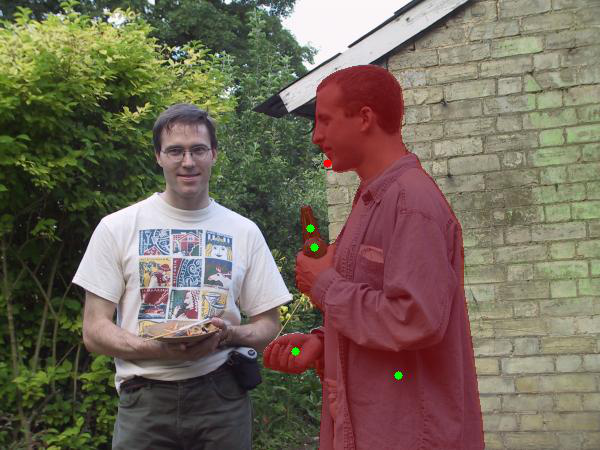

In [328]:
from imantics import Polygons, Mask, Annotation
import json
from PIL import Image
from io import BytesIO
SEG_URL = 'http:/39.105.9.150:5005/interactive_segmentation'
IMG_URL = 'http://39.105.9.150:5005/view_image/'

# gen clicks
clicker.make_next_click(pred_mask)
click_history = []
for click in clicker.clicks_list:
    (y, x, i) = click.coords_and_indx
    p = click.is_positive
    x , y, p = int(x), int(y), int(p)
    click_history.append({'x':x, 'y':y, 'positive':p, 'index': i})
    print(f'Click({i}): x:{x}, y:{y}, p:{p}')
assert click_history[-1]['index'] == len(clicker.clicks_list)-1, f'Last history is not the current click'

# gen request
result = requests.post('http://0.0.0.0:5005/interactive_segmentation', 
    data={
        # 'image': open(image_path, 'rb'),
        'click_history': json.dumps(click_history),
        'prev_polygon': json.dumps(polygons),
        'view_img': 'true'
    }, 
    files={
        'image': (image_name, open(image_path, 'rb')),
        # 'gt_mask': ('gt_mask', open()) #TODO: send gt_mask
    }
)

if result.status_code != 200:
    print(result)
else:
    #update prediction
    polygons = result.json()['polygons']
    img = Image.open(image_path)
    pred_mask = Polygons(polygons).mask(width=img.width, height=img.height).array

    #display image
    filename = result.json()['result']
    pred_img = requests.get(IMG_URL+filename)
    view_img = Image.open(BytesIO(pred_img.content))
view_img